In [2]:
# Importing Libraries 

import os, cv2, gc, itertools, pickle
from PIL import Image
import numpy as np
import pandas as pd

import albumentations as A
import matplotlib.pyplot as plt

import torch, timm, clip
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor


c:\Users\Ayush\apython\envs\gpu\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Importing skycam .csv Data: The label i.e. text feature is generated from the numeric cloud coverage.
folder = 'dataset'
df = pd.read_csv(folder+"/cloud_data_cleaned1.csv")
df = df[['image_name', 'label', 'opaque_clouds']]
df.columns = ['image', 'caption', 'cloudcover']
df.head()


,image,caption,cloudcover
0,20160101075000.jpg,Image has No Cloud Coverage. Image has 7% of o...,7
1,20160101080000.jpg,Image has No Cloud Coverage. Image has 7% of o...,7
2,20160101081000.jpg,Image has No Cloud Coverage. Image has 7% of o...,7
3,20160101082000.jpg,Image has No Cloud Coverage. Image has 7% of o...,7
4,20160101083000.jpg,Image has No Cloud Coverage. Image has 7% of o...,7


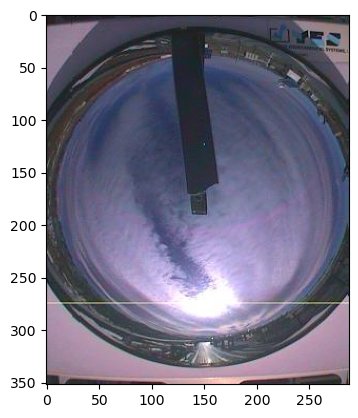

In [4]:
img_folder =os.path.join(folder, 'data_images', 'Extracted Images')
#img_filename = os.listdir(img_folder)[0]
img_path = os.path.join(img_folder, df['image'].iloc[777])

img = Image.open(img_path)
plt.imshow(img)
plt.show()


# A. Clip Model Finetuning

In [5]:
# ----- Setting up Hyper Parameters in Configurations ----- #

class CFG:
	debug = False
	image_path = img_folder # Specify your Image directory path
	captions_path = "."
	batch_size = 128
	num_workers = 4
	head_lr = 1e-3
	image_encoder_lr = 1e-4
	text_encoder_lr = 1e-5
	weight_decay = 1e-3
	patience = 3
	factor = 0.8
	epochs = 15
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	model_name = 'resnet50'
	image_embedding = 2048
	text_encoder_model = "distilbert-base-uncased"
	text_embedding = 768
	text_tokenizer = "distilbert-base-uncased"
	max_length = 200
	pretrained = True # for both image encoder and text encoder
	trainable = True # for both image encoder and text encoder
	temperature = 1.0
	size = 224
	# For projection head: used for both image and text encoders
	num_projection_layers = 1
	projection_dim = 256
	dropout = 0.1


In [6]:
# ----- Setting up Utils ----- #

class AvgMeter:
	def __init__(self, name="Metric"):
		self.name = name
		self.reset()
	def reset(self):
		self.avg, self.sum, self.count = [0] * 3
	def update(self, val, count=1):
		self.count += count
		self.sum += val * count
		self.avg = self.sum / self.count
	def __repr__(self):
		text = f"{self.name}: {self.avg:.4f}"
		return text

def get_lr(optimizer):
	for param_group in optimizer.param_groups:
		return param_group["lr"]


In [7]:
# ----- Building Custom Dataset ----- #


class CLIPDataset(torch.utils.data.Dataset):
	def __init__(self, image_filenames, captions, tokenizer, transforms):
		"""
		image_filenames and captions must have the same length; so, if there are
		multiple captions for each image, the image_filenames must have repetitive
		file names.
		"""
		self.image_filenames = image_filenames
		self.captions = list(captions)
		self.encoded_captions = tokenizer(
			list(captions), padding=True, truncation=True, max_length=CFG.max_length)
		self.transforms = transforms

	def __getitem__(self, idx):
		item = {
			key: torch.tensor(values[idx])
			for key, values in self.encoded_captions.items()
		}
		image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = self.transforms(image=image)['image']
		item['image'] = torch.tensor(image).permute(2, 0, 1).float()
		item['caption'] = self.captions[idx]
		return item

	def __len__(self):
		return len(self.captions)


def get_transforms(mode="train"):
	if mode == "train":
		return A.Compose(
			[
				A.Resize(CFG.size, CFG.size, always_apply=True),
				A.Normalize(max_pixel_value=255.0, always_apply=True),
			]
		)
	else:
		return A.Compose(
			[
				A.Resize(CFG.size, CFG.size, always_apply=True),
				A.Normalize(max_pixel_value=255.0, always_apply=True),
			]
		)


In [8]:
# ----- Image Encoder ----- #

class ImageEncoder(nn.Module):
	# Encode images to a fixed size vector
	def __init__(self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable):
		super().__init__()
		self.model = timm.create_model(
			model_name, pretrained, num_classes=0, global_pool="avg")
		for p in self.model.parameters():
			p.requires_grad = trainable

	def forward(self, x):
		return self.model(x)


In [9]:
# ----- Text Encoder ----- #

class TextEncoder(nn.Module):
	def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
		super().__init__()
		if pretrained:
			self.model = DistilBertModel.from_pretrained(model_name)
		else:
			self.model = DistilBertModel(config=DistilBertConfig())
		for p in self.model.parameters():
			p.requires_grad = trainable
		# W are using the CLS token hidden representation as the sentence's embedding
		self.target_token_idx = 0

	def forward(self, input_ids, attention_mask):
		output = self.model(input_ids=input_ids, attention_mask=attention_mask)
		last_hidden_state = output.last_hidden_state
		return last_hidden_state[:, self.target_token_idx, :]


In [10]:
# ----- Projection Head ----- #

class ProjectionHead(nn.Module):
	def __init__(
		self,
		embedding_dim,
		projection_dim=CFG.projection_dim,
		dropout=CFG.dropout
	):
		super().__init__()
		self.projection = nn.Linear(embedding_dim, projection_dim)
		self.gelu = nn.GELU()
		self.fc = nn.Linear(projection_dim, projection_dim)
		self.dropout = nn.Dropout(dropout)
		self.layer_norm = nn.LayerNorm(projection_dim)

	def forward(self, x):
		projected = self.projection(x)
		x = self.gelu(projected)
		x = self.fc(x)
		x = self.dropout(x)
		x = x + projected
		x = self.layer_norm(x)
		return x


In [11]:
# ----- CLIP Model Define ----- #

class CLIPModel(nn.Module):
	def __init__(
		self,
		temperature=CFG.temperature,
		image_embedding=CFG.image_embedding,
		text_embedding=CFG.text_embedding,
	):
		super().__init__()
		self.image_encoder = ImageEncoder()
		self.text_encoder = TextEncoder()
		self.image_projection = ProjectionHead(embedding_dim=image_embedding)
		self.text_projection = ProjectionHead(embedding_dim=text_embedding)
		self.temperature = temperature

	def forward(self, batch):
		# Getting Image and Text Features
		image_features = self.image_encoder(batch["image"])
		text_features = self.text_encoder(
			input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
		)
		# Getting Image and Text Embeddings (with same dimension)
		image_embeddings = self.image_projection(image_features)
		text_embeddings = self.text_projection(text_features)
		# Calculating the Loss
		logits = (text_embeddings @ image_embeddings.T) / self.temperature
		images_similarity = image_embeddings @ image_embeddings.T
		texts_similarity = text_embeddings @ text_embeddings.T
		targets = F.softmax(
			(images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
		)
		texts_loss = cross_entropy(logits, targets, reduction='none')
		images_loss = cross_entropy(logits.T, targets.T, reduction='none')
		loss = (images_loss + texts_loss) / 2.0 # shape: (batch_size)
		return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
	log_softmax = nn.LogSoftmax(dim=-1)
	loss = (-targets * log_softmax(preds)).sum(1)
	if reduction == "none":
		return loss
	elif reduction == "mean":
		return loss.mean()


In [12]:
# ----- Training Methods ----- #

def make_train_valid_dfs(df):
	# First 1,30,000 records for training
	train_dataframe = df.iloc[:130000, :]
	valid_dataframe = df.iloc[130000:, :] # Last 30k records for validation
	return train_dataframe.reset_index(drop=True), valid_dataframe.reset_index(drop=True)

def build_loaders(dataframe, tokenizer, mode):
	transforms = get_transforms(mode=mode)
	dataset = CLIPDataset(
		dataframe["image"].values,
		dataframe["caption"].values,
		tokenizer=tokenizer,
		transforms=transforms,
	)
	dataloader = torch.utils.data.DataLoader(
		dataset,
		batch_size=CFG.batch_size,
		num_workers=CFG.num_workers,
		shuffle=True if mode == "train" else False,
	)
	return dataloader

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
	loss_meter = AvgMeter()
	tqdm_object = tqdm(train_loader, total=len(train_loader))
	for batch in tqdm_object:
		batch = {k: v.to(CFG.device)
				for k, v in batch.items() if k != "caption"}
		loss = model(batch)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		if step == "batch":
			lr_scheduler.step()
		count = batch["image"].size(0)
		loss_meter.update(loss.item(), count)
		tqdm_object.set_postfix(
			train_loss=loss_meter.avg, lr=get_lr(optimizer))
	return loss_meter

def valid_epoch(model, valid_loader):
	loss_meter = AvgMeter()
	tqdm_object = tqdm(valid_loader, total=len(valid_loader))
	for batch in tqdm_object:
		batch = {k: v.to(CFG.device)
				for k, v in batch.items() if k != "caption"}
		loss = model(batch)
		count = batch["image"].size(0)
		loss_meter.update(loss.item(), count)
		tqdm_object.set_postfix(valid_loss=loss_meter.avg)
	return loss_meter


In [13]:
print(CFG.device)

cuda


In [14]:
# ----- Train-Valid Split ----- #

train_df, valid_df = make_train_valid_dfs(df) 
print(len(train_df), len(valid_df))
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


130000 3654


c:\Users\Ayush\apython\envs\gpu\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
# ----- Loading Pretrained Model ----- #

model = CLIPModel().to(CFG.device)
params = [
	{"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
	{"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
	{"params": itertools.chain(
		model.image_projection.parameters(), model.text_projection.parameters()
	), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
	optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)


In [ ]:
# ----- Model Training ----- #
# print(device)
print("Training Started!")
step = "epoch"
model.to(CFG.device)

best_loss = float('inf')
for epoch in range(CFG.epochs):
	print(f"Epoch: {epoch + 1}")
	model.train()
	train_loss = train_epoch(
		model, train_loader, optimizer, lr_scheduler, step)
	model.eval()
	with torch.no_grad():
		valid_loss = valid_epoch(model, valid_loader)
	if valid_loss.avg < best_loss:
		best_loss = valid_loss.avg
		torch.save(model.state_dict(), "CLIP_model.pt")
		print("Saved Best Model!")
	lr_scheduler.step(valid_loss.avg)


Training Started!
Epoch: 1


  0%|          | 0/1016 [00:00<?, ?it/s]

In [ ]:
with open('clip_mdl.pkl', 'wb') as f:
	pickle.dump(model, f)
with open('clip_cfg.pkl', 'wb') as f:
	pickle.dump(CFG, f)


In [ ]:
x = df['image']
y = df['cloudcover']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=48)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=48)

print((x_train.shape, x_val.shape, x_test.shape))


((70168,), (30072,), (33414,))


In [ ]:
model = CLIPModel().to(CFG.device)
model.load_state_dict(torch.load("clip_model.pt", map_location = CFG.device))
model.eval()


TypeError: OptimizedCLIPModel.__init__() missing 1 required positional argument: 'cfg'

In [ ]:
# ----- Custom Dataset Loader ----- #
class SkyImage(Dataset):
	def __init__(self, img_dir, labels):
		self.img_dir = img_dir
		self.img_labels = labels
	def __len__(self):
		return len(self.img_dir)
	def __getitem__(self, idx):
		img_path = os.path.join(img_folder, self.img_dir[idx])
		#os.path.join("Extracted Images/", self.img_dir[idx])
		image = cv2.imread(img_path)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (244, 244))
		image = np.moveaxis(image, -1, 0)
		label = self.img_labels[idx]
		return image, label

# ----- Dataset ----- #
train_images = SkyImage(x_train.to_list(), y_train.to_list())
valid_images = SkyImage(x_val.to_list(), y_val.to_list())
test_images = SkyImage(x_test.to_list(), y_test.to_list())


In [ ]:
# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


In [ ]:
# ----- Building Features ----- #

def get_features(dataset):
	all_features, all_labels, all_embeddings = [], [], []
	with torch.no_grad():
		for images, labels in tqdm(DataLoader(dataset, batch_size=64)):
			image_input = torch.tensor(np.stack(images)).to(device).float()
			image_features = model.image_encoder(image_input)
			image_embeddings = model.image_projection(image_features)
			all_features.append(image_features)
			all_labels.append(labels)
			all_embeddings.append(image_embeddings)
	return torch.cat(all_features), torch.cat(all_labels).to(device), torch.cat(all_embeddings).to(device)

# ----- Get Features ----- #

train_features, train_labels, train_embeddings = get_features(train_images)
valid_features, valid_labels, valid_embeddings = get_features(valid_images)
test_features, test_labels, test_embeddings = get_features(test_images)


In [ ]:
def evaluate(name, x, y, n, p): # p: features, #n: no of observations
	print("---------------------------------------------------")
	print("{} MAE: {}".format(name, mean_absolute_error(x, y)))
	print("{} RMSE: {}".format(name, mean_squared_error(x, y, squared=False)))
	print("{} MSE: {}".format(name, mean_squared_error(x, y)))
	r2 = r2_score(x, y)
	print("{} R2: {}".format(name, r2))
	print("---------------------------------------------------")


In [ ]:
# ----- Model Training ----- #

CB_model = CatBoostRegressor(iterations=700, learning_rate=0.1, max_depth=8, eval_metric='RMSE', random_seed=48)
CB_model.fit(train_features.cpu().numpy(), train_labels.cpu().numpy(),
			eval_set = (valid_features.cpu().numpy(), valid_labels.cpu().numpy()),
			use_best_model=True, plot=True, verbose=50)


In [ ]:
# ----- Model Prediction ----- #

cbt_train_pred = CB_model.predict(train_features.cpu().numpy())
cbt_valid_pred = CB_model.predict(valid_features.cpu().numpy())
cbt_test_pred = CB_model.predict(test_features.cpu().numpy())


In [ ]:
# ----- Model Evaluation ----- #

evaluate("Train", train_labels.cpu(), cbt_train_pred, len(cbt_train_pred), 1)
evaluate("Valid", valid_labels.cpu(), cbt_valid_pred, len(cbt_valid_pred), 1)
evaluate("Test", test_labels.cpu(), cbt_test_pred, len(cbt_test_pred), 1)


In [ ]:
pickle.dump(CB_model, open('catboost_model.sav', 'wb'))

In [10]:
import json
import pickle
import pandas as pd

# opens the pickle file
with open('clip_mdl.pkl', 'rb') as input_file:
    # loads the pickle file into a pandas DataFrame
    data = pd.read_pickle(input_file)


data

OptimizedCLIPModel(
  (image_encoder): MemoryEfficientImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kerne

In [11]:
# converts the DataFrame to JSON and write it to a file
data.to_json('data.json', orient='columns')

AttributeError: 'OptimizedCLIPModel' object has no attribute 'to_json'